## Problem 1:

### You are hired by one of the leading news channel CNBE who wants to analyze recent elections. This survey was conducted on 1525 voters with 9 variables. You have to build a model, to predict which party a voter will vote for on the basis of the given information, to create an exit poll that will help in predicting overall win and seats covered by a particular party.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix
import math
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xlsxwriter
import xlrd

In [4]:
xls = pd.ExcelFile('Election_Data.xlsx')

df = pd.read_excel(xls, 'Election_Dataset_Two Classes')
df = df.drop('Unnamed: 0', axis=1)

## 1. Read the dataset. Do the descriptive statistics and do null value condition check. Write an inference on it.


In [5]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,Labour,43,3,3,4,1,2,2,female
1,Labour,36,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,2,male
3,Labour,24,4,2,2,1,4,0,female
4,Labour,41,2,2,1,1,6,2,male


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political.knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 107.4+ KB


In [7]:
df.shape

(1525, 9)

In [8]:
df.describe()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000
mean,54.182295,3.245902,3.140328,3.334426,2.746885,6.728525,1.542295
std,15.711209,0.880969,0.929951,1.174824,1.230703,3.297538,1.083315
min,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,41.000000,3.000000,3.000000,2.000000,2.000000,4.000000,0.000000
50%,53.000000,3.000000,3.000000,4.000000,2.000000,6.000000,2.000000
75%,67.000000,4.000000,4.000000,4.000000,4.000000,10.000000,2.000000
max,93.000000,5.000000,5.000000,5.000000,5.000000,11.000000,3.000000


In [9]:
df['vote'].value_counts(normalize=True)

Labour          0.697049
Conservative    0.302951
Name: vote, dtype: float64

Labour class constitute 69% of vote whereas Conservative class has 30% of vote
Our model prediction will be more apt for the Labour class party

In [10]:
df['gender'].value_counts(normalize=True)

female    0.532459
male      0.467541
Name: gender, dtype: float64

Female shows higher percentage than male

### Null Value check

In [11]:
df.isnull().sum()

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

There is no null value in the dataset 

### Duplicate Value check

In [12]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df[dups]

Number of duplicate rows = 8


,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
67,Labour,35,4,4,5,2,3,2,male
626,Labour,39,3,4,4,2,5,2,male
870,Labour,38,2,4,2,2,4,3,male
983,Conservative,74,4,3,2,4,8,2,female
1154,Conservative,53,3,4,2,2,6,0,female
1236,Labour,36,3,3,2,2,6,2,female
1244,Labour,29,4,4,4,2,2,2,female
1438,Labour,40,4,3,4,2,2,2,male


In [13]:
df = df.drop_duplicates()

In [14]:
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
df[dups]

Number of duplicate rows = 0


,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender


Duplicates have been removed 

In [15]:
for column in df.columns:
    if df[column].dtype == 'object':
        print(column.upper(),': ',df[column].nunique())
        print(df[column].value_counts().sort_values())
        print('\n')

VOTE :  2
Conservative     460
Labour          1057
Name: vote, dtype: int64


GENDER :  2
male      709
female    808
Name: gender, dtype: int64




### 1.2) Perform Univariate and Bivariate Analysis. Do exploratory data analysis. Check for Outliers.

In [16]:
df.size

13653

In [17]:
df.shape

(1517, 9)

### Univariate Analysis 

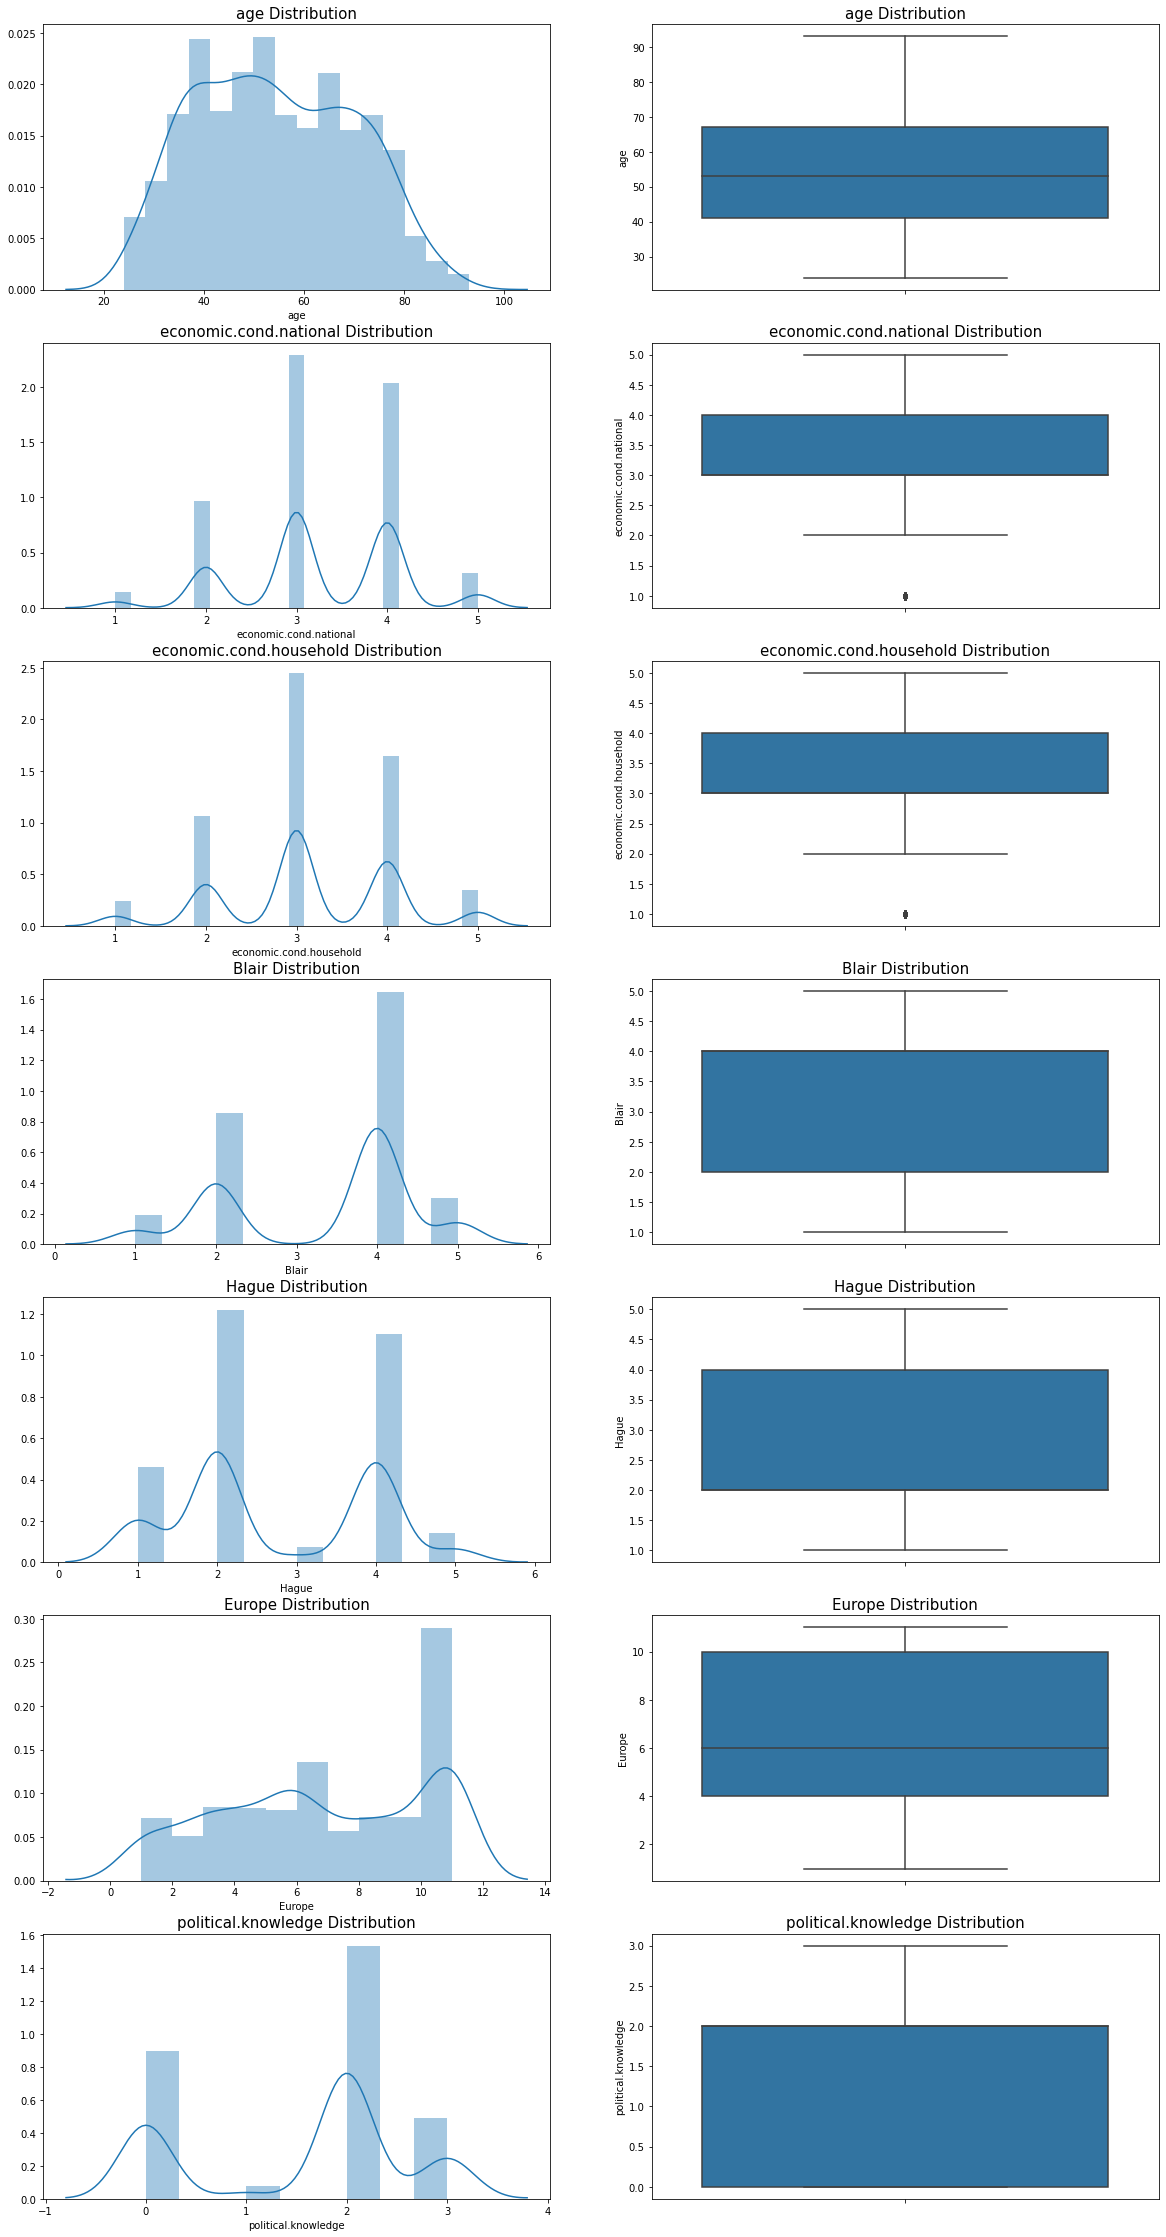

In [18]:
fig, axes = plt.subplots(nrows=7,ncols=2)
fig.set_size_inches(20, 40)

a = sns.distplot(df['age'] , ax=axes[0][0])
a.set_title("age Distribution",fontsize=15)
a = sns.boxplot(df['age'] , orient = "v" , ax=axes[0][1])
a.set_title("age Distribution",fontsize=15)

a = sns.distplot(df['economic.cond.national'] , ax=axes[1][0])
a.set_title("economic.cond.national Distribution",fontsize=15)

a = sns.boxplot(df['economic.cond.national'] , orient = "v" , ax=axes[1][1])
a.set_title("economic.cond.national Distribution",fontsize=15)

a = sns.distplot(df['economic.cond.household'] , ax=axes[2][0])
a.set_title("economic.cond.household Distribution",fontsize=15)

a = sns.boxplot(df['economic.cond.household'] , orient = "v" , ax=axes[2][1])
a.set_title("economic.cond.household Distribution",fontsize=15)


a = sns.distplot(df['Blair'] , ax=axes[3][0])
a.set_title("Blair Distribution",fontsize=15)

a = sns.boxplot(df['Blair'] , orient = "v" , ax=axes[3][1])
a.set_title("Blair Distribution",fontsize=15)

a = sns.distplot(df['Hague'] , ax=axes[4][0])
a.set_title("Hague Distribution",fontsize=15)

a = sns.boxplot(df['Hague'] , orient = "v" , ax=axes[4][1])
a.set_title("Hague Distribution",fontsize=15)

a = sns.distplot(df['Europe'] , ax=axes[5][0])
a.set_title("Europe Distribution",fontsize=15)

a = sns.boxplot(df['Europe'] , orient = "v" , ax=axes[5][1])
a.set_title("Europe Distribution",fontsize=15)

a = sns.distplot(df['political.knowledge'] , ax=axes[6][0])
a.set_title("political.knowledge Distribution",fontsize=15)

a = sns.boxplot(df['political.knowledge'] , orient = "v" , ax=axes[6][1])
a.set_title("political.knowledge Distribution",fontsize=15)

plt.show()

### Checking for Outliers 

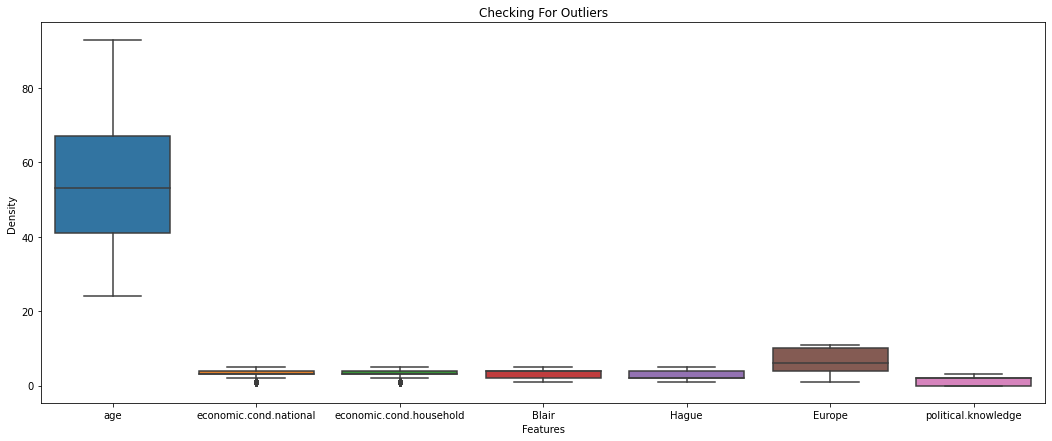

In [19]:

plt.figure(figsize=(18,7));
sns.boxplot(data=df);
plt.title('Checking For Outliers');
plt.xlabel('Features');
plt.ylabel('Density');

### Countplots from Election Dataset

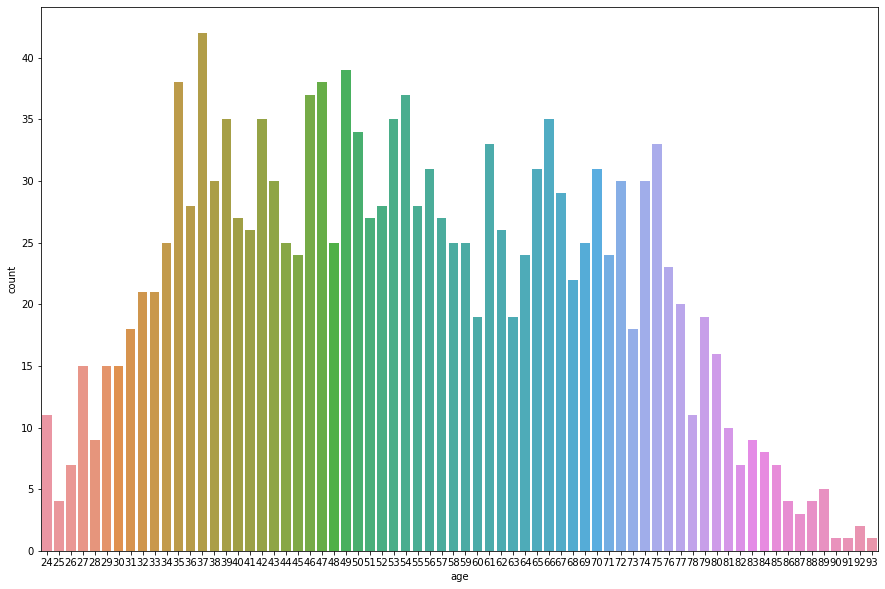

In [20]:
plt.figure(figsize=(15,10));
sns.countplot(x='age', data=df);

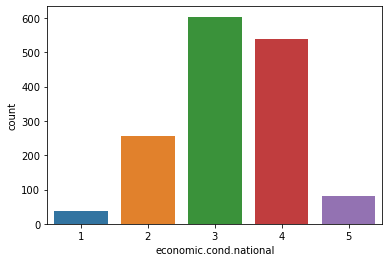

In [21]:
sns.countplot(x='economic.cond.national', data=df);

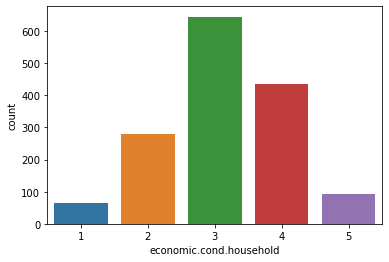

In [22]:
sns.countplot(x='economic.cond.household', data=df );

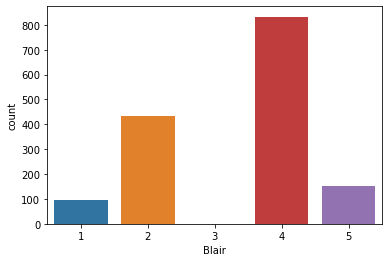

In [23]:
sns.countplot(x='Blair', data=df );

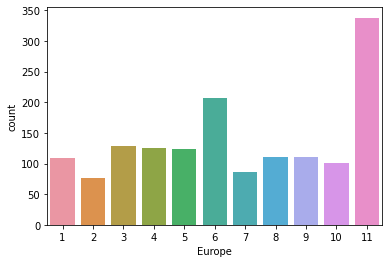

In [24]:
sns.countplot(x='Europe', data=df );

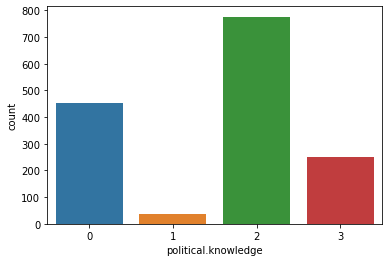

In [25]:
sns.countplot(x='political.knowledge', data=df );

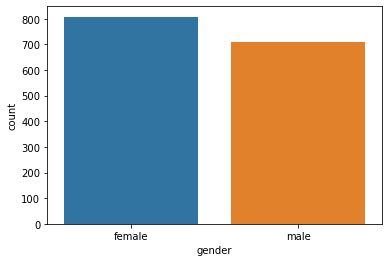

In [26]:
sns.countplot(x='gender', data=df );

### Correlation

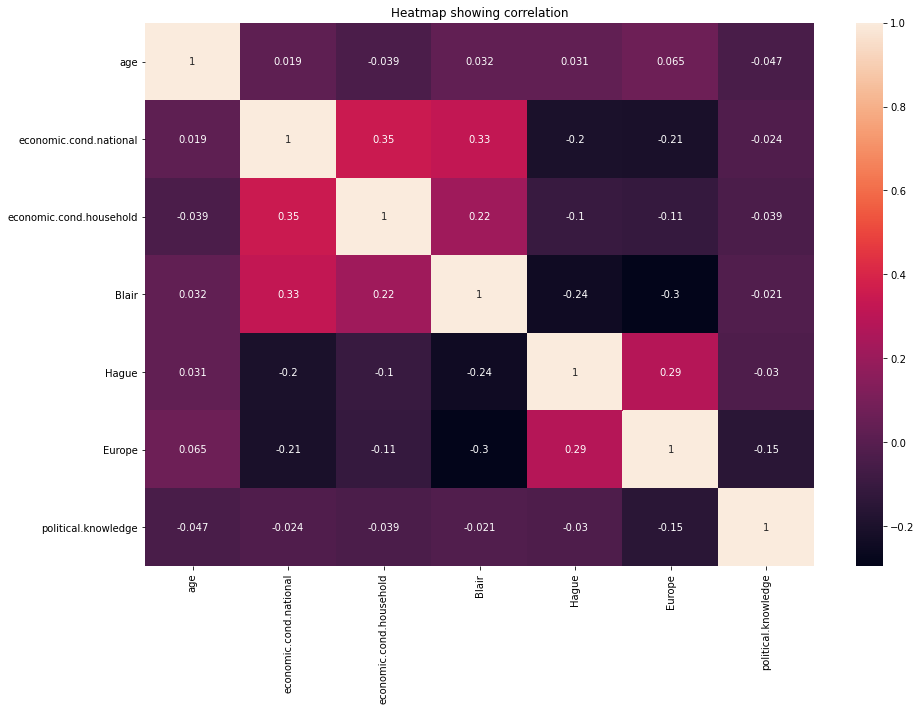

In [27]:
plt.figure(figsize=(15,10));
sns.heatmap(df.corr(), annot=True)
plt.title('Heatmap showing correlation');
plt.show()

There is not much correlation between the variables.

### Bivariate Analysis

In [28]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,Labour,43,3,3,4,1,2,2,female
1,Labour,36,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,2,male
3,Labour,24,4,2,2,1,4,0,female
4,Labour,41,2,2,1,1,6,2,male


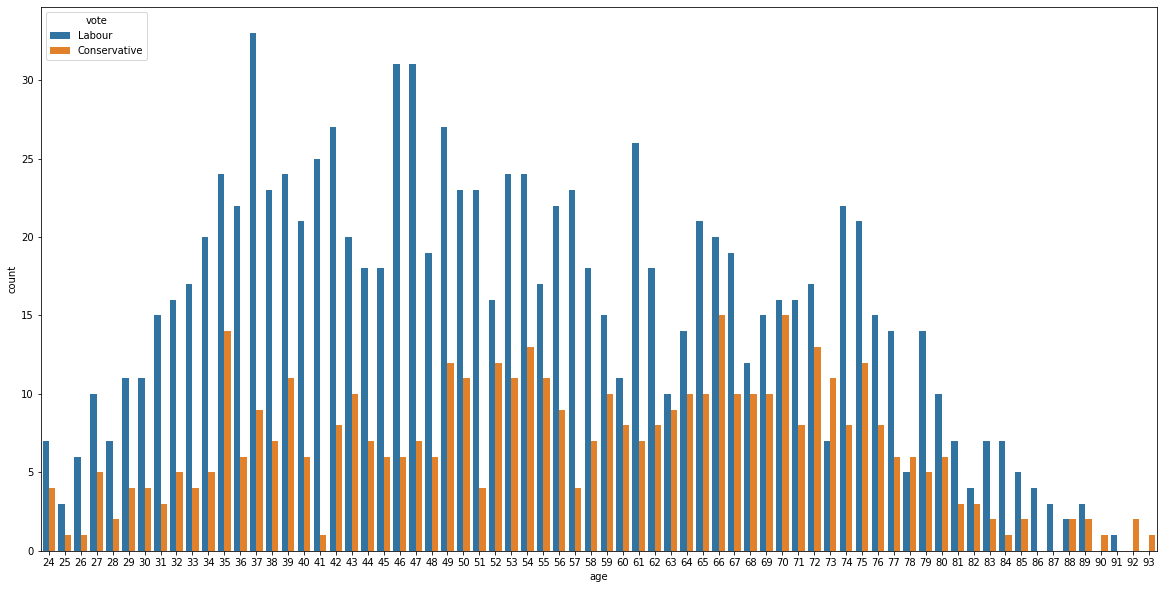

In [29]:
plt.figure(figsize=(20,10));
sns.countplot(x='age', data=df, hue='vote');

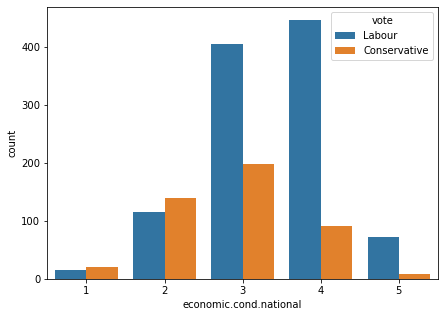

In [30]:
plt.figure(figsize=(7,5));
sns.countplot(x='economic.cond.national', data=df, hue='vote');

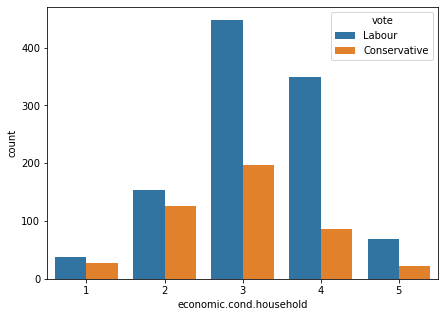

In [31]:
plt.figure(figsize=(7,5));
sns.countplot(x='economic.cond.household', data=df, hue='vote');

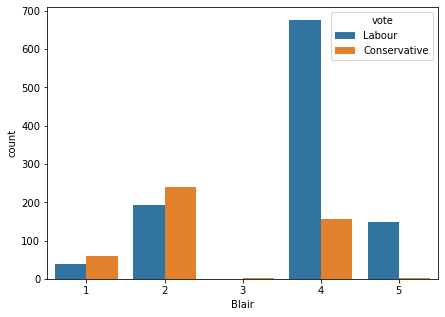

In [32]:
plt.figure(figsize=(7,5));
sns.countplot(x='Blair', data=df, hue='vote');

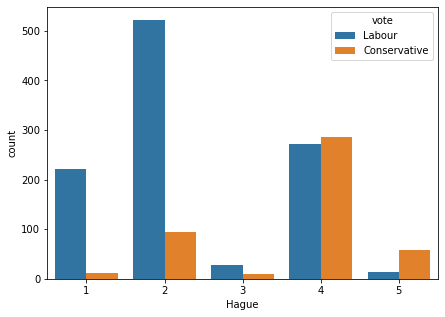

In [33]:
plt.figure(figsize=(7,5));
sns.countplot(x='Hague', data=df, hue='vote');

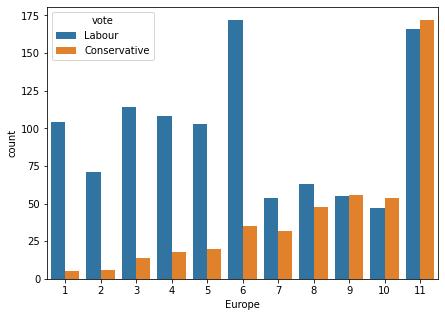

In [34]:
plt.figure(figsize=(7,5));
sns.countplot(x='Europe', data=df, hue='vote');

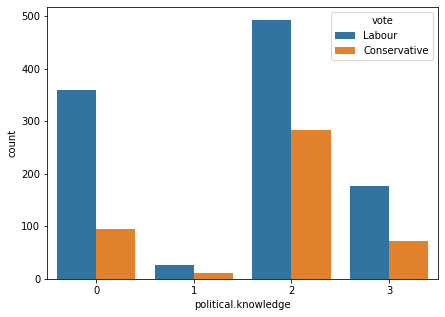

In [35]:
plt.figure(figsize=(7,5));
sns.countplot(x='political.knowledge', data=df, hue='vote');

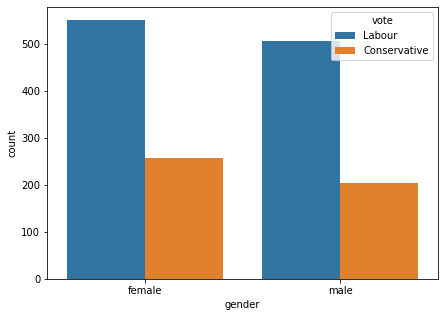

In [36]:
plt.figure(figsize=(7,5));
sns.countplot(x='gender', data=df, hue='vote');

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


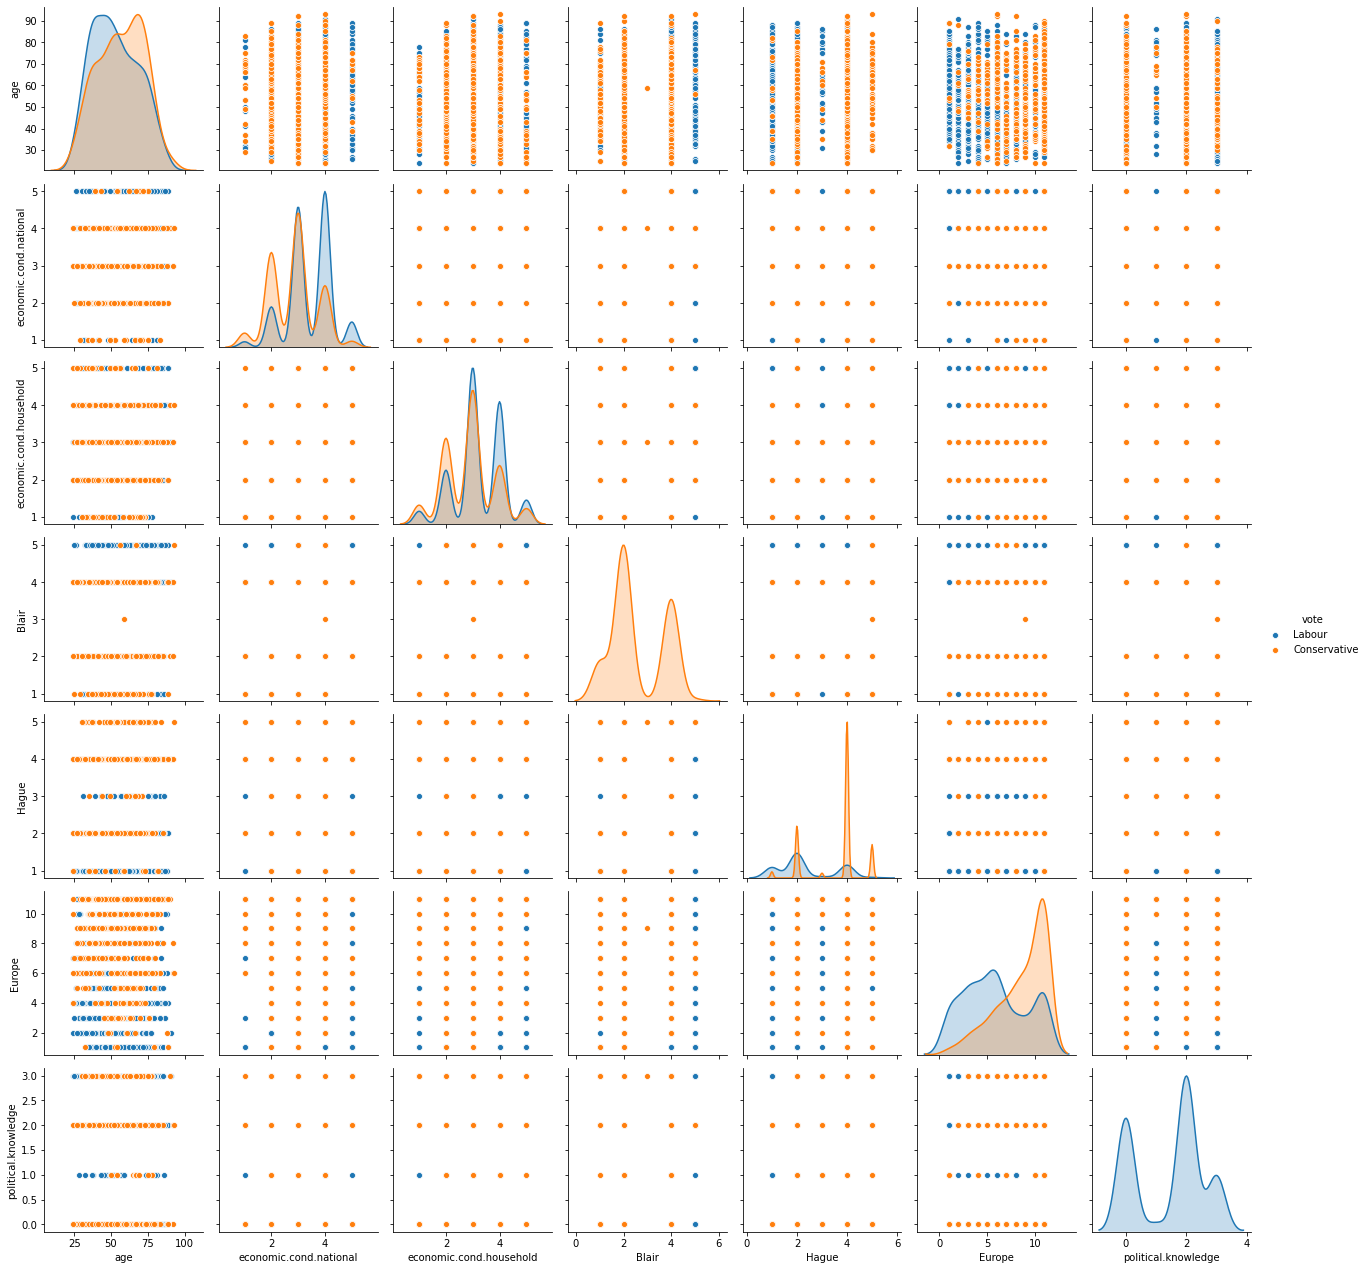

In [37]:
sns.pairplot(df,hue="vote");

### 1.3) Encode the data (having string values) for Modelling. Is Scaling necessary here or not? Data Split: Split the data into train and test (70:30).

In [38]:
for feature in df.columns:
       if df[feature].dtype =='object':
        print('\n')
        print('feature:', feature)
        print(pd.Categorical(df[feature].unique()))
        print(pd.Categorical(df[feature].unique()).codes)
        df[feature] = pd.Categorical(df[feature]).codes



feature: vote
[Labour, Conservative]
Categories (2, object): [Conservative, Labour]
[1 0]


feature: gender
[female, male]
Categories (2, object): [female, male]
[0 1]


In [39]:
# predictor variable into X dataframe
X=df.drop('vote',axis=1)

# Copy target into the y dataframe. 
y = df[['vote']]

### Splitting the data in 70:30

In [40]:
# Split X and y into training and test set in 70:30 ratio
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1)

In [41]:
print('Shape of X_train', X_train.shape)
print('Shape of X_test', X_test.shape)
print('Shape of y_train', y_train.shape)
print('Shape of y_test', X_test.shape)

Shape of X_train (1061, 8)
Shape of X_test (456, 8)
Shape of y_train (1061, 1)
Shape of y_test (456, 8)


In [42]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,1,43,3,3,4,1,2,2,0
1,1,36,4,4,4,4,5,2,1
2,1,35,4,4,5,2,3,2,1
3,1,24,4,2,2,1,4,0,0
4,1,41,2,2,1,1,6,2,1


### 1.4) Apply Logistic Regression and LDA (Linear Discriminant Analysis).

## Modelling

### Apply Logistic Regression and LDA (linear discriminant analysis).

#### LDA Basic

In [43]:
#from sklearn.discriminant_analysis import LinerDiscriminantAnalysis
LDA_Model = LinearDiscriminantAnalysis()
LDA_Model.fit(X_train,y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LinearDiscriminantAnalysis()

### Performance Matrix on train data set 

In [44]:
y_train_predict = LDA_Model.predict(X_train)
model_score = LDA_Model.score(X_train,y_train)
print(model_score)
print(metrics.confusion_matrix(y_train,y_train_predict))
print(metrics.classification_report(y_train,y_train_predict))

0.8341187558906692
[[200 107]
 [ 69 685]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       307
           1       0.86      0.91      0.89       754

    accuracy                           0.83      1061
   macro avg       0.80      0.78      0.79      1061
weighted avg       0.83      0.83      0.83      1061



### Performance Matrix on test data set

In [45]:
y_test_predict = LDA_Model.predict(X_test)
model_score = LDA_Model.score(X_test,y_test)
print(model_score)
print(metrics.confusion_matrix(y_test,y_test_predict))
print(metrics.classification_report(y_test,y_test_predict))

0.8333333333333334
[[111  42]
 [ 34 269]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.74       153
           1       0.86      0.89      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.83      0.83       456



### AUC and ROC for the Training data (LDA)

AUC: 0.889


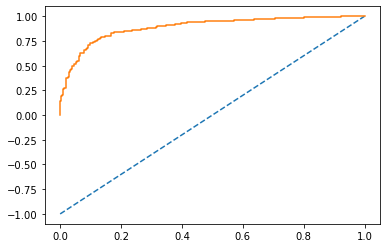

In [46]:
# predict probabilities
probs = LDA_Model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0,1], [-1,1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the Test data (LDA)

AUC: 0.889


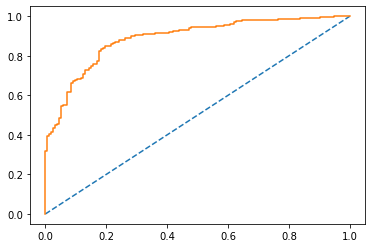

In [47]:
# predict probabilities
probs =  LDA_Model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

#### Logistic Regression

In [48]:
Logit_model = LogisticRegression(solver='newton-cg',max_iter=1000, penalty='none',verbose=True,n_jobs=2)
Logit_model.fit(X_train,y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    0.6s finished


LogisticRegression(max_iter=1000, n_jobs=2, penalty='none', solver='newton-cg',
                   verbose=True)

### Performance Matrix on train data set (Logistic Regression)

In [49]:
y_train_predict = Logit_model.predict(X_train)
model_score = Logit_model.score(X_train,y_train)
print(model_score)
print(metrics.confusion_matrix(y_train,y_train_predict))
print(metrics.classification_report(y_train,y_train_predict))

0.8312912346842601
[[196 111]
 [ 68 686]]
              precision    recall  f1-score   support

           0       0.74      0.64      0.69       307
           1       0.86      0.91      0.88       754

    accuracy                           0.83      1061
   macro avg       0.80      0.77      0.79      1061
weighted avg       0.83      0.83      0.83      1061



### Performance Matrix on test data set (Logistic Regression)

In [50]:
y_train_predict = Logit_model.predict(X_test)
model_score = Logit_model.score(X_test,y_test)
print(model_score)
print(metrics.confusion_matrix(y_test,y_test_predict))
print(metrics.classification_report(y_test,y_test_predict))

0.8355263157894737
[[111  42]
 [ 34 269]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.74       153
           1       0.86      0.89      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.83      0.83       456



### AUC and ROC for the train data (Logistic Regression)

AUC: 0.890


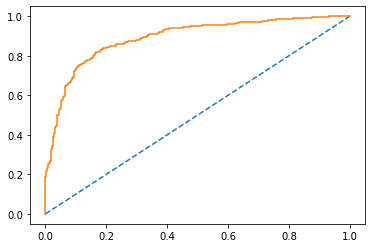

In [51]:
# predict probabilities
probs = Logit_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (Logistic Regression)

AUC: 0.890


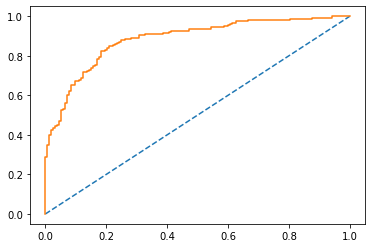

In [52]:
# predict probabilities
probs = Logit_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

### 1.5) Apply KNN Model and Naïve Bayes Model

#### Applying scaling on Age variable for KNN model only

In [53]:
num1 = ['age']
X_scaled=X.copy()
y_new = y.copy()
X_scaled[num1]=X_scaled[num1].apply(lambda x:(x-x.mean())/(x.std()))

In [54]:
X_scaled.head()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,-0.715925,3,3,4,1,2,2,0
1,-1.161735,4,4,4,4,5,2,1
2,-1.225422,4,4,5,2,3,2,1
3,-1.925982,4,2,2,1,4,0,0
4,-0.843299,2,2,1,1,6,2,1


## KNN - Basic

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_new, test_size=0.30 , random_state=1)

In [56]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None,n_neighbors=5,p=2,weights='uniform')
KNN_model.fit(X_train,y_train)

<ipython-input-56-7ac61270df90>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  KNN_model.fit(X_train,y_train)


KNeighborsClassifier()

In [57]:
## Performance Matrix on train data set
y_train_predict = KNN_model.predict(X_train)
model_score = KNN_model.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8614514608859567
[[223  84]
 [ 63 691]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       307
           1       0.89      0.92      0.90       754

    accuracy                           0.86      1061
   macro avg       0.84      0.82      0.83      1061
weighted avg       0.86      0.86      0.86      1061



In [58]:
## Performance Matrix on test data set
y_test_predict = KNN_model.predict(X_test)
model_score = KNN_model.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8223684210526315
[[102  51]
 [ 30 273]]
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       153
           1       0.84      0.90      0.87       303

    accuracy                           0.82       456
   macro avg       0.81      0.78      0.79       456
weighted avg       0.82      0.82      0.82       456



### AUC and ROC for the train data (KNN)

AUC: 0.930


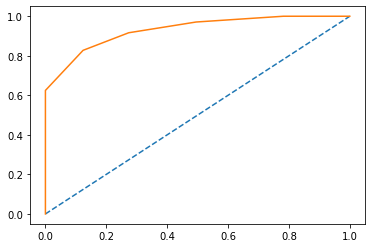

In [59]:
# predict probabilities
probs = KNN_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (KNN)

AUC: 0.930


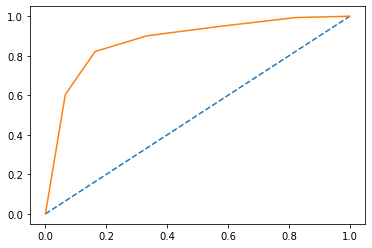

In [60]:
# predict probabilities
probs = KNN_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

## NB - Basic

In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
NB_model = GaussianNB()
NB_model.fit(X_train, y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GaussianNB()

In [62]:
## Performance Matrix on train data set
y_train_predict = NB_model.predict(X_train)
model_score = NB_model.score(X_train, y_train)                      ## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))          ## confusion_matrix
print(metrics.classification_report(y_train, y_train_predict))     ## classification_report

0.8350612629594723
[[211  96]
 [ 79 675]]
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       307
           1       0.88      0.90      0.89       754

    accuracy                           0.84      1061
   macro avg       0.80      0.79      0.80      1061
weighted avg       0.83      0.84      0.83      1061



In [63]:
## Performance Matrix on test data set
y_test_predict = NB_model.predict(X_test)
model_score = NB_model.score(X_test, y_test)                    ## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))         ## confusion_matrix
print(metrics.classification_report(y_test, y_test_predict))    ## classification_report

0.8223684210526315
[[112  41]
 [ 40 263]]
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       153
           1       0.87      0.87      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.80      0.80       456
weighted avg       0.82      0.82      0.82       456



### AUC and ROC for the train data (NB)

AUC: 0.888


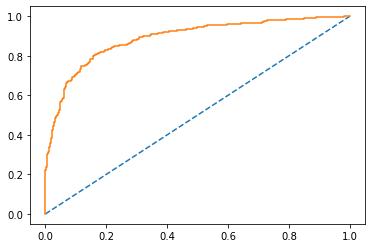

In [64]:
# predict probabilities
probs = NB_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (NB)

AUC: 0.888


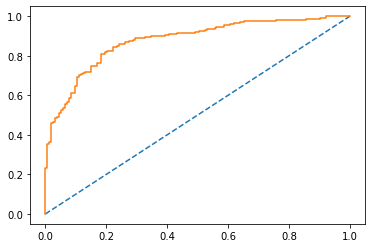

In [65]:
# predict probabilities
probs = NB_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

### 1.6) Model Tuning, Bagging and Boosting.

## Bagging - Basic (Base estimator is used as RF)

In [66]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
cart = RandomForestClassifier()
Bagging_model = BaggingClassifier(base_estimator=cart, n_estimators=100,random_state=1)
Bagging_model.fit(X_train, y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


BaggingClassifier(base_estimator=RandomForestClassifier(), n_estimators=100,
                  random_state=1)

In [67]:
## Performance Matrix on train data set
y_train_predict = Bagging_model.predict(X_train)
model_score = Bagging_model.score(X_train, y_train)                      ## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))          ## confusion_matrix
print(metrics.classification_report(y_train, y_train_predict))     ## classification_report

0.9679547596606974
[[277  30]
 [  4 750]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       307
           1       0.96      0.99      0.98       754

    accuracy                           0.97      1061
   macro avg       0.97      0.95      0.96      1061
weighted avg       0.97      0.97      0.97      1061



Base estimator is used as RF

In [68]:
## Performance Matrix on test data set
y_test_predict = Bagging_model.predict(X_test)
model_score = Bagging_model.score(X_test, y_test)                    ## Accuracy
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))         ## confusion_matrix
print(metrics.classification_report(y_test, y_test_predict))    ## classification_report

0.8289473684210527
[[104  49]
 [ 29 274]]
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       153
           1       0.85      0.90      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.79      0.80       456
weighted avg       0.83      0.83      0.83       456



### AUC and ROC for the train data (Bagging)

AUC: 0.997


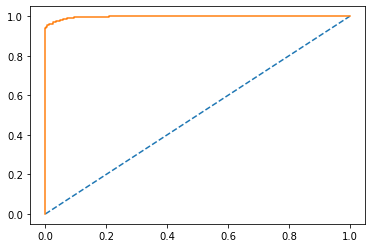

In [69]:
# predict probabilities
probs = Bagging_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (Bagging)

AUC: 0.997


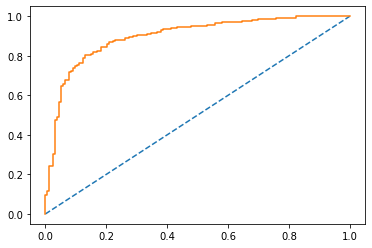

In [70]:
# predict probabilities
probs = Bagging_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

## AdaBoost - Basic

In [71]:
from sklearn.ensemble import AdaBoostClassifier
ADB_model = AdaBoostClassifier(n_estimators=100,random_state=1)
ADB_model.fit(X_train,y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


AdaBoostClassifier(n_estimators=100, random_state=1)

In [72]:
## Performance Matrix on train data set
y_train_predict = ADB_model.predict(X_train)
model_score = ADB_model.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8501413760603205
[[214  93]
 [ 66 688]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       307
           1       0.88      0.91      0.90       754

    accuracy                           0.85      1061
   macro avg       0.82      0.80      0.81      1061
weighted avg       0.85      0.85      0.85      1061



In [73]:
## Performance Matrix on test data set
y_test_predict = ADB_model.predict(X_test)
model_score = ADB_model.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8135964912280702
[[103  50]
 [ 35 268]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       153
           1       0.84      0.88      0.86       303

    accuracy                           0.81       456
   macro avg       0.79      0.78      0.79       456
weighted avg       0.81      0.81      0.81       456



### AUC and ROC for the train data (AdaBoost)

AUC: 0.915


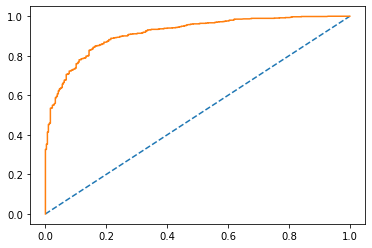

In [74]:
# predict probabilities
probs = ADB_model.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (AdaBoost)

AUC: 0.915


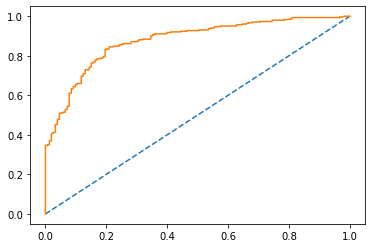

In [75]:
# predict probabilities
probs = ADB_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

## Gradient Boosting : Basic

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(random_state=1)
gbcl = gbcl.fit(X_train, y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [77]:
## Performance Matrix on train data set
y_train_predict = gbcl.predict(X_train)
model_score = gbcl.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8925541941564562
[[239  68]
 [ 46 708]]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       307
           1       0.91      0.94      0.93       754

    accuracy                           0.89      1061
   macro avg       0.88      0.86      0.87      1061
weighted avg       0.89      0.89      0.89      1061



In [78]:
## Performance Matrix on test data set
y_test_predict = gbcl.predict(X_test)
model_score = gbcl.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8355263157894737
[[105  48]
 [ 27 276]]
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       153
           1       0.85      0.91      0.88       303

    accuracy                           0.84       456
   macro avg       0.82      0.80      0.81       456
weighted avg       0.83      0.84      0.83       456



## AUC and ROC for the train data (Gradient Boosting)

AUC: 0.951


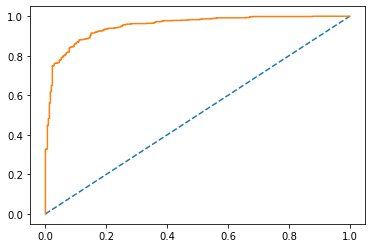

In [79]:
# predict probabilities
probs = gbcl.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

## AUC and ROC for the test data (Gradient Boosting)

AUC: 0.951


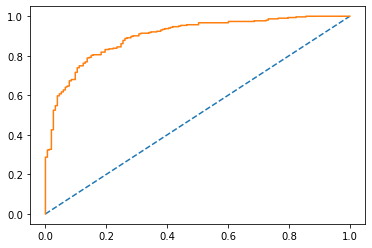

In [80]:
# predict probabilities
probs = gbcl.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

## Model Tuning

### LDA - GridSearch

In [81]:
from sklearn.model_selection import GridSearchCV

In [82]:
estimator_1 = LinearDiscriminantAnalysis()
parameters_1 = { 'solver' : ('lsqr', 'eigen'),'n_components':(1,5,1),}

In [83]:
# with GridSearch
clf = GridSearchCV(estimator=estimator_1,param_grid=parameters_1,cv=5,n_jobs=-1,scoring='f1')

In [84]:
LDA_model = clf.fit(X_train,y_train)
LDA_model

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'n_components': (1, 5, 1),
                         'solver': ('lsqr', 'eigen')},
             scoring='f1')

In [85]:
clf.best_params_

{'n_components': 1, 'solver': 'lsqr'}

In [86]:
best_grid = clf.best_estimator_

In [87]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [88]:
## Performance Matrix on train data set
y_train_predict = best_grid.predict(X_train)
model_score = best_grid.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8341187558906692
[[200 107]
 [ 69 685]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       307
           1       0.86      0.91      0.89       754

    accuracy                           0.83      1061
   macro avg       0.80      0.78      0.79      1061
weighted avg       0.83      0.83      0.83      1061



In [89]:
## Performance Matrix on test data set
y_test_predict = best_grid.predict(X_test)
model_score = best_grid.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8333333333333334
[[111  42]
 [ 34 269]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.74       153
           1       0.86      0.89      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.81      0.81       456
weighted avg       0.83      0.83      0.83       456



### AUC and ROC for the train data (LDA-GridSearch)

AUC: 0.889


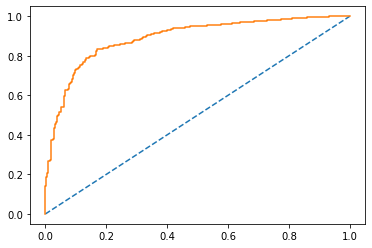

In [90]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (LDA-GridSearch)

AUC: 0.889


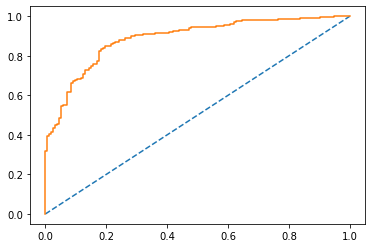

In [91]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

## LOGIT - GridSearchCV

In [92]:
clf = LogisticRegression()
grid_values = {'penalty':['l1','l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],'solver':['newton-cg']}
Logit_model = GridSearchCV(clf,param_grid=grid_values,cv=5)
Logit_model.fit(X_train,y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\ankitsharma04\Anaconda3\

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detai

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2'], 'solver': ['newton-cg']})

In [93]:
Logit_model.best_params_

{'C': 0.09, 'penalty': 'l2', 'solver': 'newton-cg'}

In [94]:
Logit_model.best_estimator_

LogisticRegression(C=0.09, solver='newton-cg')

In [95]:
best_grid = Logit_model.best_estimator_

In [96]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [97]:
## Performance Matrix on train data set
y_train_predict = best_grid.predict(X_train)
model_score = best_grid.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8322337417530632
[[192 115]
 [ 63 691]]
              precision    recall  f1-score   support

           0       0.75      0.63      0.68       307
           1       0.86      0.92      0.89       754

    accuracy                           0.83      1061
   macro avg       0.81      0.77      0.78      1061
weighted avg       0.83      0.83      0.83      1061



In [98]:
## Performance Matrix on test data set
y_test_predict = best_grid.predict(X_test)
model_score = best_grid.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.831140350877193
[[111  42]
 [ 35 268]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       153
           1       0.86      0.88      0.87       303

    accuracy                           0.83       456
   macro avg       0.81      0.80      0.81       456
weighted avg       0.83      0.83      0.83       456



## AUC and ROC for the train data (LOGIT-GridSearch)

AUC: 0.890


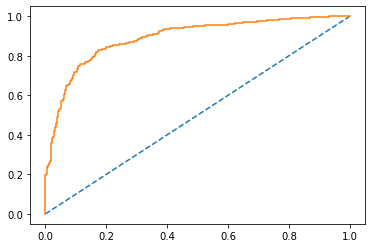

In [99]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

## AUC and ROC for the test data (LOGIT-GridSearch)

AUC: 0.890


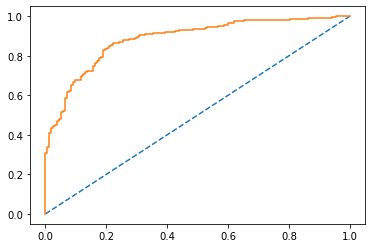

In [100]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

### KNN- Grid Search

In [101]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_scaled, y_new, test_size=0.30 , random_state=1)

In [102]:
clf = KNeighborsClassifier()
param_grid = {'leaf_size':[20,30,50],
             'n_neighbors':[10,20,30],
             'p':[1,2]}
KNN_model = GridSearchCV(clf,param_grid=param_grid,cv=5)
KNN_model.fit(X1_train,y1_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConv

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConv

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConv

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [20, 30, 50], 'n_neighbors': [10, 20, 30],
                         'p': [1, 2]})

In [103]:
KNN_model.best_params_

{'leaf_size': 30, 'n_neighbors': 10, 'p': 2}

In [104]:
KNN_model.best_estimator_

KNeighborsClassifier(n_neighbors=10)

In [105]:
best_grid = KNN_model.best_estimator_

In [106]:
ytrain_predict = best_grid.predict(X1_train)
ytest_predict = best_grid.predict(X1_test)

In [107]:
## Performance Matrix on train data set
y_train_predict = best_grid.predict(X1_train)
model_score = best_grid.score(X1_train, y1_train)
print(model_score)
print(metrics.confusion_matrix(y1_train, y_train_predict))
print(metrics.classification_report(y1_train, y_train_predict))

0.8510838831291234
[[223  84]
 [ 74 680]]
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       307
           1       0.89      0.90      0.90       754

    accuracy                           0.85      1061
   macro avg       0.82      0.81      0.82      1061
weighted avg       0.85      0.85      0.85      1061



In [108]:
## Performance Matrix on test data set
y_test_predict = best_grid.predict(X1_test)
model_score = best_grid.score(X1_test, y1_test)
print(model_score)
print(metrics.confusion_matrix(y1_test, y_test_predict))
print(metrics.classification_report(y1_test, y_test_predict))

0.8333333333333334
[[112  41]
 [ 35 268]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.75       153
           1       0.87      0.88      0.88       303

    accuracy                           0.83       456
   macro avg       0.81      0.81      0.81       456
weighted avg       0.83      0.83      0.83       456



## AUC and ROC for the train data (KNN-GridSearch)

AUC: 0.916


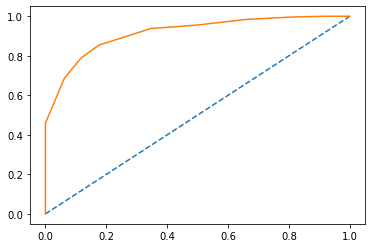

In [109]:
# predict probabilities
probs = best_grid.predict_proba(X1_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

## AUC and ROC for the test data (KNN-GridSearch)

AUC: 0.916


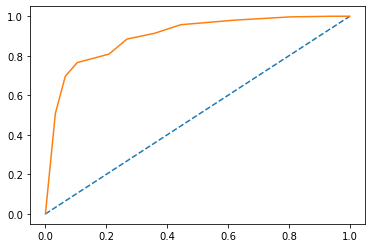

In [110]:
# predict probabilities
probs = best_grid.predict_proba(X1_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

## NB - GRID SEARCH

In [111]:
clf = GaussianNB()
grid_values = {"var_smoothing" :[1e-8,1e-7,1e-6,1e-5,1e-4]}
NB_model = GridSearchCV(clf,param_grid=grid_values,cv=5,n_jobs=1,verbose=2)
NB_model.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-08 .............................................
[CV] .............................. var_smoothing=1e-08, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] .............................. var_smoothing=1e-07, total=   0.0s
[CV] var_smoothing=1e-07 .............................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=1,
             param_grid={'var_smoothing': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001]},
             verbose=2)

In [112]:
NB_model.best_params_

{'var_smoothing': 1e-08}

In [113]:
NB_model.best_estimator_

GaussianNB(var_smoothing=1e-08)

In [114]:
best_grid = NB_model.best_estimator_

In [115]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [116]:
## Performance Matrix on train data set
y_train_predict = best_grid.predict(X_train)
model_score = best_grid.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8350612629594723
[[211  96]
 [ 79 675]]
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       307
           1       0.88      0.90      0.89       754

    accuracy                           0.84      1061
   macro avg       0.80      0.79      0.80      1061
weighted avg       0.83      0.84      0.83      1061



In [117]:
## Performance Matrix on test data set
y_test_predict = best_grid.predict(X_test)
model_score = best_grid.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8223684210526315
[[112  41]
 [ 40 263]]
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       153
           1       0.87      0.87      0.87       303

    accuracy                           0.82       456
   macro avg       0.80      0.80      0.80       456
weighted avg       0.82      0.82      0.82       456



## AUC and ROC for the train data (NB-GridSearch)

AUC: 0.888


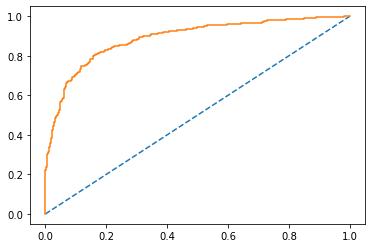

In [118]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

## AUC and ROC for the test data (NB-GridSearch)

AUC: 0.888


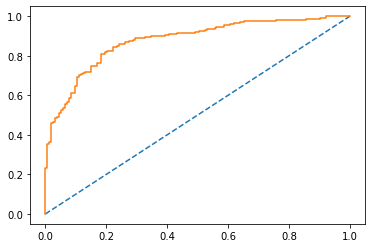

In [119]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

### Bagging model with Grid Search

In [120]:
grid = {"max_samples":[0.5,1.0],
       "max_features":[1,2,4],
       "bootstrap":[True,False]
       }
rfcl = BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=100,random_state=1)
grid_search = GridSearchCV(estimator=rfcl,param_grid=grid,cv=3)

In [121]:
grid_search.fit(X_train,y_train)
grid_search.best_params_

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

{'bootstrap': False, 'max_features': 4, 'max_samples': 0.5}

In [122]:
grid_search.best_params_
best_grid = grid_search.best_estimator_

In [123]:
ytrain_predict = best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

### Base estimator is used as RF Classifier

In [124]:
## Performance Matrix on train data set
y_train_predict = best_grid.predict(X_train)
model_score = best_grid.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.9236569274269557
[[238  69]
 [ 12 742]]
              precision    recall  f1-score   support

           0       0.95      0.78      0.85       307
           1       0.91      0.98      0.95       754

    accuracy                           0.92      1061
   macro avg       0.93      0.88      0.90      1061
weighted avg       0.93      0.92      0.92      1061



In [125]:
## Performance Matrix on test data set
y_test_predict = best_grid.predict(X_test)
model_score = best_grid.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8135964912280702
[[ 85  68]
 [ 17 286]]
              precision    recall  f1-score   support

           0       0.83      0.56      0.67       153
           1       0.81      0.94      0.87       303

    accuracy                           0.81       456
   macro avg       0.82      0.75      0.77       456
weighted avg       0.82      0.81      0.80       456



### AUC and ROC for the train data (Bagging-GridSearch)

AUC: 0.982


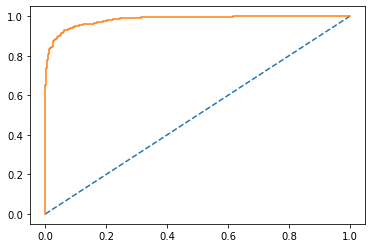

In [126]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (Bagging-GridSearch)

AUC: 0.982


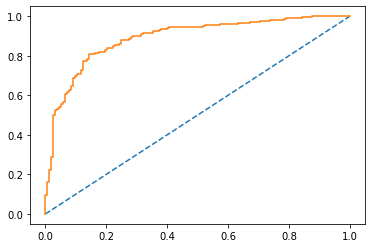

In [127]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

### Ada Boost with Grid Search

In [128]:
ada = AdaBoostClassifier()
search_grid={'n_estimators':[500,1000,2000], 'learning_rate':[0.001,0.01,.1]}
search = GridSearchCV(estimator=ada,param_grid=search_grid,n_jobs=1,cv=3)

In [129]:
search.fit(X_train,y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

GridSearchCV(cv=3, estimator=AdaBoostClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [500, 1000, 2000]})

In [130]:
search.best_params_
best_grid=Logit_model.best_estimator_

In [131]:
ytrain_predict=best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [132]:
## Performance Matrix on train data set
y_train_predict = best_grid.predict(X_train)
model_score = best_grid.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.8322337417530632
[[192 115]
 [ 63 691]]
              precision    recall  f1-score   support

           0       0.75      0.63      0.68       307
           1       0.86      0.92      0.89       754

    accuracy                           0.83      1061
   macro avg       0.81      0.77      0.78      1061
weighted avg       0.83      0.83      0.83      1061



In [133]:
## Performance Matrix on test data set
y_test_predict = best_grid.predict(X_test)
model_score = best_grid.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.831140350877193
[[111  42]
 [ 35 268]]
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       153
           1       0.86      0.88      0.87       303

    accuracy                           0.83       456
   macro avg       0.81      0.80      0.81       456
weighted avg       0.83      0.83      0.83       456



### AUC and ROC for the train data (Ada Boost-GridSearch)

AUC: 0.890


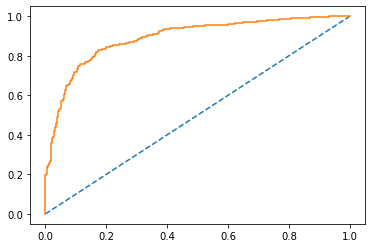

In [134]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (Ada Boost-GridSearch)

AUC: 0.890


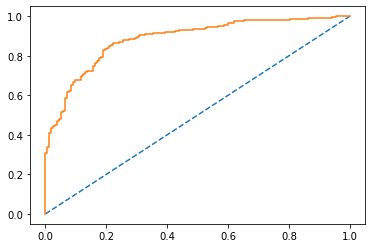

In [135]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

### Gradient Boosting with Grid Search

In [138]:
clf = GradientBoostingClassifier()
grid_values={"loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
        "n_estimators":[10]}

In [139]:
gb_model = GridSearchCV(clf,param_grid=grid_values,cv=5,n_jobs=2)
gb_model.fit(X_train,y_train)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=2,
             param_grid={'criterion': ['friedman_mse', 'mae'],
                         'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15,
                                           0.2],
                         'loss': ['deviance'], 'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [10]})

In [140]:
gb_model.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 10}

In [141]:
best_grid = gb_model.best_estimator_
best_grid

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='sqrt',
                           n_estimators=10)

In [142]:
ytrain_predict=best_grid.predict(X_train)
ytest_predict = best_grid.predict(X_test)

In [143]:
## Performance Matrix on train data set
y_train_predict = best_grid.predict(X_train)
model_score = best_grid.score(X_train, y_train)
print(model_score)
print(metrics.confusion_matrix(y_train, y_train_predict))
print(metrics.classification_report(y_train, y_train_predict))

0.884071630537229
[[220  87]
 [ 36 718]]
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       307
           1       0.89      0.95      0.92       754

    accuracy                           0.88      1061
   macro avg       0.88      0.83      0.85      1061
weighted avg       0.88      0.88      0.88      1061



In [144]:
## Performance Matrix on test data set
y_test_predict = best_grid.predict(X_test)
model_score = best_grid.score(X_test, y_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_test_predict))
print(metrics.classification_report(y_test, y_test_predict))

0.8289473684210527
[[100  53]
 [ 25 278]]
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       153
           1       0.84      0.92      0.88       303

    accuracy                           0.83       456
   macro avg       0.82      0.79      0.80       456
weighted avg       0.83      0.83      0.82       456



### AUC and ROC for the train data (Gradient Boost-GridSearch)

AUC: 0.944


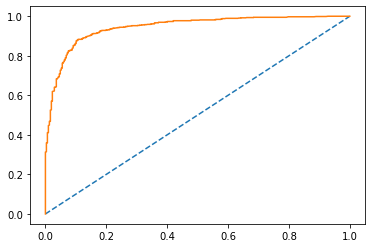

In [146]:
# predict probabilities
probs = best_grid.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(train_fpr, train_tpr);

### AUC and ROC for the test data (Gradient Boost-GridSearch)

AUC: 0.944


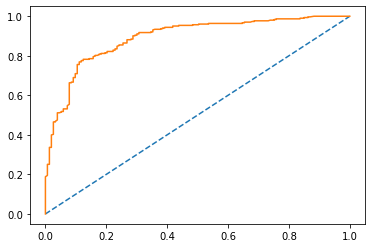

In [147]:
# predict probabilities
probs = best_grid.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
test_auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(test_fpr, test_tpr);

In [169]:
classifiers = [LogisticRegression(random_state=1), 
               LinearDiscriminantAnalysis(),
              KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None,n_neighbors=5,p=2,weights='uniform'),
              GaussianNB(),
              BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=100,random_state=1),
              AdaBoostClassifier(),
              GradientBoostingClassifier()]

In [170]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [171]:
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-171-752e55c93ce7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model = cls.fit(X_train, y_train)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

In [172]:
result_table.set_index('classifiers', inplace=True)

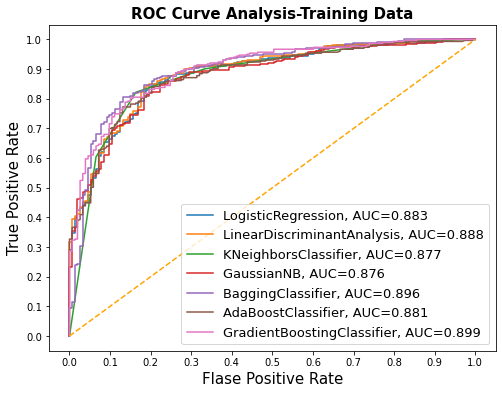

In [173]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis-Training Data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [174]:
classifiers1 = [LogisticRegression(random_state=1), 
               LinearDiscriminantAnalysis(),
              KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None,n_neighbors=5,p=2,weights='uniform'),
              GaussianNB(),
              BaggingClassifier(base_estimator=RandomForestClassifier(),n_estimators=100,random_state=1),
              AdaBoostClassifier(),
              GradientBoostingClassifier()]

In [175]:
result_table1 = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [176]:
for cls in classifiers1:
    model = cls.fit(X_test, y_test)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table1 = result_table1.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
<ipython-input-176-efb8eb7a1de4>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model = cls.fit(X_test, y_test)
C:\Users\ankitsharma04\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kw

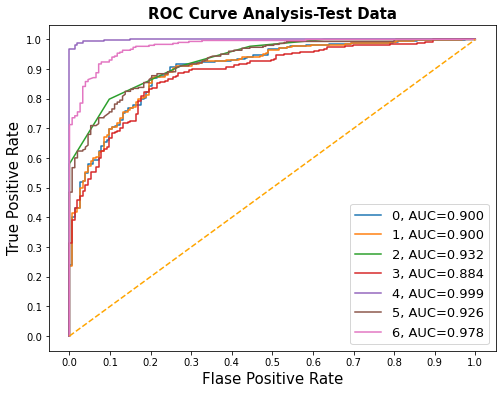

In [177]:
fig = plt.figure(figsize=(8,6))

for i in result_table1.index:
    plt.plot(result_table1.loc[i]['fpr'], 
             result_table1.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table1.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis-Test Data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()